In this module, we study how to implement the density-based clustering algorithm. We focus on DBSCAN (density-based spatial clustering of applications with noise) and then move on to discuss other types of density-based clustering algorithms. 

Compared to centroid-based clustering like K-Means, density-based clustering works by identifying 'dense' clusters of points, allowing it to learn clusters of arbitrary shape and identify outliers in the data. Among all density-based clustering algorithms, DBSCAN is the most famous one. Unlike K-Means, DBSCAN does not require the number of clusters as a parameter. Rather it infers the number of clusters based on the data, and it can discover clusters of arbitrary shape (for comparison, K-Means usually discovers spherical clusters). 

To understand DBSCAN further, we need to first define a few things and go back to the idea of neighborhoods in point-set topology. It turns out the most common method to define density is the center-based approach, in which density is estimated for a particular point in the dataset by counting the number of points within a specified radius of that point (this includes the point itself). This way allows us to classify a point as being 1) in the interior of a dense region (a **core point**), or 2) on the edge of a dense region (a **border point**) or 3) in a sparsely occupied region (a **noise point ** or **background point**). In particular, a core point satisfies its definition if the number of points within a given neighborhood around the point as determined by the distance function and a user-specified distance parameter, exceeds a certain value. A border point is not a core point, but falls within the neighborhood of a core point. A noise point is neither a core point nor a border point. To implement the basic idea for DBSCAN, any two core points that are close enough are put in the same cluster. Likewise, any border point that is close enough to a core point is put in the same cluster as the core point. Noise points are discarded.

In the next section, we explore DBSCAN in detail. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

%matplotlib inline

Before we move on, let's understand the related definitions in a more intuitive way. Since we are talking about density-based clustering, we first need to understand the meaning of density. In grade schools, we learned through physics class that density equals mass divided volume. Let’s use this idea of to define density at some point x. If we consider some point x and its neighborhood of radius $\epsilon>0$, we can define the mass of the neighborhood as the number of data points (or alternatively, the fraction of data points) contained within the neighborhood, and the volume of the neighborhood is volume of the resulting shape of the neighborhood. In the 2D case, the neighborhood is a circle, so the volume of the neighborhood is just the area of the resulting circle. In the 3D and higher dimensional case, the neighborhood is a sphere or n-sphere, so we can calculate the volume of this shape based on results from measure theory (see Frank Jones 'Measure Theory and Integration'). As an example, let’s consider our neighborhood of x = (3,2) of radius $\epsilon=1$. Suppose there are 31 points contained in this neighborhood, then we will have $mass=31$ and $volume=\pi \epsilon^2=\pi$. And so density will equal 31 divided by $\pi$. Notice that this value is meaningless by itself, but if we calculate the local density approximation for all points in our dataset, we could cluster our points by saying that points that are nearby (contained in the same neighborhood) and have similar local density approximations belong in the same cluster. If we decrease the value of the radius, we can construct smaller neighborhoods (less volume) that would also contain fewer data points. Ideally, we want to identify highly dense neighborhoods where most of the data points are contained in these neighborhoods, but the volume of each of these neighborhoods is relatively small (high density). Note that this is not exactly what DBSCAN does, but the idea certainly carries over. Also, notice that core Points are the foundations for our clusters. Since we choose the radius on our own, the volume of all the neighborhoods is the same. However, the number of other points in each neighborhood is what differs. Recall that we can think of the number of data points in the neighborhood as its mass. The volume of each neighborhood is constant, and the mass of neighborhood is variable, so by putting a threshold on the minimum amount of mass needed to be core point, we are essentially setting a minimum density threshold.

Given the discussions above, it is thus not hard to imagine that we have two hyperparameters for DBSCAN: 1) the radius of the neighborhood: $\epsilon>0$, and 2) the minimum number of data points we want in a neighborhood to define a cluster (denoted by the argument _minPt_). Let $N(x, \epsilon)$ denotes the neighborhood around a point x. In common metric spaces like the Euclidean space, this is the same as an open ball. Now using these two hyperparameters, DBSCAN categories the data points into three categories as specified below:

   1. Given a fixed  $\epsilon>0$, a data point x is a core point if $N(x, \epsilon)$ contains at least _minPts_. Core points are essentially data points that satisfy a minimum density requirement.
   2.  Given a fixed $\epsilon>0$, a data point x is a border point if $N(x, \epsilon)$ contains less than _minPts_ data points, but x is **reachable** from some core point y.
   3. A data point x is a noise point if it's neither a core point nor a border point. These are fundamentally outliers, which are not assigned to any cluster and, depending on the context, may be considered anomalous points.
   
We have not defined what it means to be reachable (some authors use a similar concept called density-reachable). But we can use an analogy here. Essentially, we can think of density-reachable points as being the 'friends of a friend'. If the directly-reachable of a core point p are its 'friends', then the density-reachable points, points in neighborhood of the 'friends' of p, are the 'friends of its friends'. One thing that may not be clear is density-reachable points is not limited to just two adjacent neighborhood jumps. As long as you can reach the point doing 'neighborhood jumps', starting at a core point p, that point is density-reachable from p, so 'friends of a friend of a friend ... of a friend' are included as well.

Let's visually examine the concept of reachability. Consider the point r (the black dot) that is outside of the point p's neighborhood (radius=0.15 for now):

In [2]:
os.chdir("C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets")

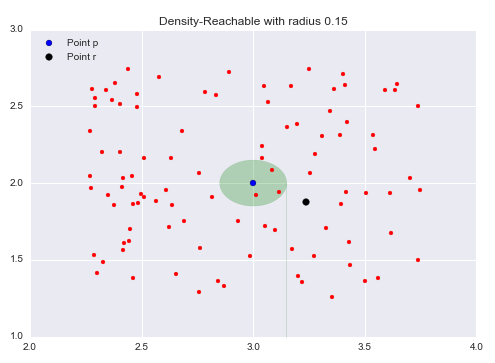

In [3]:
from IPython.display import Image
Image("Capture1.PNG") 

All the points inside the point p‘s neighborhood are said to be directly reachable from p. Now, let's explore the neighborhood of point q, a point directly reachable from p. The yellow circle represents q's neighborhood:

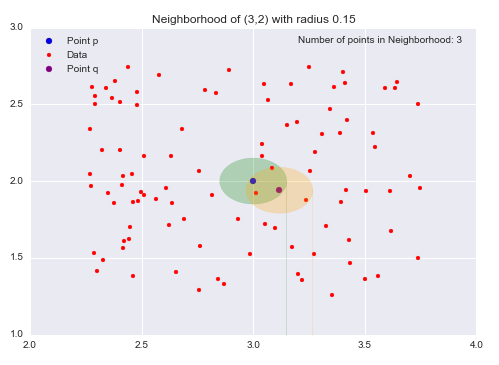

In [4]:
from IPython.display import Image
Image("Capture2.PNG") 

Now while our target point r is not our starting point p's neighborhood, it is contained in the point q's neighborhood. This is the idea behind density-reachable: If I can get to the point r by jumping from neighborhood to neighborhood, starting at a point p, then the point r is density-reachable from the point p:

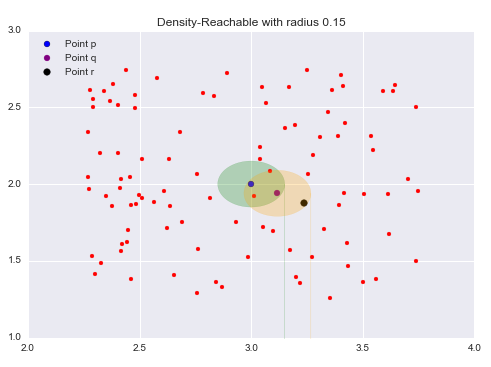

In [5]:
from IPython.display import Image
Image("Capture3.PNG") 

It is important to keep in mind that this idea of density-reachable is dependent on our value of the radius parameter. By picking larger values of the radius, more points become density-reachable, and by choosing smaller values of the radius, less points become density-reachable.

Now let's write down the precise algorithm for DBSCAN. The steps to the DBSCAN algorithm are:

   1. Pick a point at random that has not been assigned to a cluster or been designated as an outlier. Compute its neighborhood to determine if it’s a core point. If yes, start a cluster around this point. If no, label the point as an outlier.
   2. Once we find a core point and thus a cluster, expand the cluster by adding all directly-reachable points to the cluster. Perform 'neighborhood jumps' to find all density-reachable points and add them to the cluster. If an an outlier is added, change that point's status from outlier to border point.
   3. Repeat these two steps until all points are either assigned to a cluster or designated as an outlier.

Let's use a real dataset for illustration that can be retrieved from the UCI machine learning repository. This is a dataset consisting of annual customer data for a wholesale distributor. It contains 440 customers and has 8 attributes for each of these customers:

In [6]:
data = pd.read_csv("Wholesale customers data.csv")
print(data.head(10), '\n')
data.info()

   Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669   9656     7561     214              2674   
1        2       3   7057   9810     9568    1762              3293   
2        2       3   6353   8808     7684    2405              3516   
3        1       3  13265   1196     4221    6404               507   
4        2       3  22615   5410     7198    3915              1777   
5        2       3   9413   8259     5126     666              1795   
6        2       3  12126   3199     6975     480              3140   
7        2       3   7579   4956     9426    1669              3321   
8        1       3   5963   3648     6192     425              1716   
9        2       3   6006  11093    18881    1159              7425   

   Delicassen  
0        1338  
1        1776  
2        7844  
3        1788  
4        5185  
5        1451  
6         545  
7        2566  
8         750  
9        2098   

<class 'pandas.core.frame.DataFrame'>
Ra

Now let's do some data cleaning. First, observe that channel and regions are categorical in nature, we need to drop them because DBSCAN only handles numeric data. We can also visualize the data later, since we plan to use only two of these attributes: 1) groceries: the customer’s annual spending (in some monetary unit) on grocery products, and 2) milk: the customer’s annual spending (in some monetary unit) on milk products. Moreover, because the values of the data are in the thousands, we are going to normalize each attribute by scaling it to zero mean and unit variance. We restrict our attention to the subset of the data where the 'Region' is set to be 1 and the 'Channel' is set to be 1 as well:

In [7]:
print('Data Before subsetting:\n')
print(data.Channel.value_counts(),'\n')
print(data.Region.value_counts(),'\n')
data1 = data.loc[(data.Region == 1) & (data.Channel==1)]
print('Data After subsetting:\n')
print(data1.Channel.value_counts(),'\n')
print(data1.Region.value_counts(),'\n')
data1 = data1[["Grocery", "Milk"]].reset_index(drop=True)
data1.head(10)

Data Before subsetting:

1    298
2    142
Name: Channel, dtype: int64 

3    316
1     77
2     47
Name: Region, dtype: int64 

Data After subsetting:

1    59
Name: Channel, dtype: int64 

1    59
Name: Region, dtype: int64 



,Grocery,Milk
0,4897,7209
1,6824,2154
2,2112,2280
3,9490,11487
4,2216,685
5,5226,891
6,950,780
7,5838,3748
8,1393,1895
9,2062,1012


In [8]:
data2 = data1.as_matrix().astype("float32", copy = False)
stscaler = StandardScaler().fit(data2)
data3 = stscaler.transform(data2)
print('sample data (data3-in arrays form) look like this: \n', data3[0:9]) # getting a sample of 10 points to look at
print(type(data3))

sample data (data3-in arrays form) look like this: 
 [[ 0.24199064  0.78343523]
 [ 0.7774539  -0.40270022]
 [-0.53188854 -0.37313482]
 [ 1.51826596  1.78725076]
 [-0.50298965 -0.74739516]
 [ 0.33341119 -0.69905812]
 [-0.85477817 -0.7251038 ]
 [ 0.50347012 -0.02867453]
 [-0.73167998 -0.46347353]]
<class 'numpy.ndarray'>


Notice that the dataset is a numpy's 'ndarray' object here. We have the dataset that are all numeric values in nature. So now let's perform the DBSCAN algorithm:

In [9]:
dbsc = DBSCAN(eps = 0.2, min_samples =3).fit(data3)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # this is the number of clusters in labels, ignoring noise if present

try:
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data2, labels))
except ValueError:
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Value Error: please retune your hyperparameters!')
    
print('\nFirst few labels:\n', labels[0:9])

Estimated number of clusters: 3
Silhouette Coefficient: 0.206

First few labels:
 [-1 -1  0 -1  0 -1  0 -1  0]


A few points to make here. First, the np.zeros_like() function return an array of zeros with the same shape and type as a given array. It essentially 'zeroes the object out' while keeping the shape and type of the object (so here the shape of the object 'labels' gets kept but all elements are zeroed out for the new object 'core_samples', and the 'dtype = bool' commands change this object into a vector of 'False' for every element). Here, the 'labels' object contains all the labels for each cluster and noisy samples are given the label of -1. Second, the try...except clause is used becuase sometimes our tuning parameter is not set up correctly and it may result in a 'Value Error'. 

Now let's visualize the data. Here in the code below, we see 3 clusters (colored in circular shapes) and outlier points (black dots). Lining up with our intuition, the DBSCAN algorithm was able to identify clusters of 'normal' customers. In addition, it was able to flag customers whose annual purchasing behavior deviated too heavily from other customers. From a business standpoint, because the outliers corresponded to customers with more extreme purchasing behavior, the wholesale distributor could specifically target these customers with exclusive discounts to encourage larger purchases.

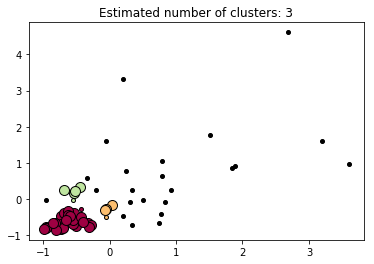

In [10]:
unique_labels = set(labels) 
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # black used for noise

    class_member_mask = (labels == k)

    xy = data3[class_member_mask & core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = data3[class_member_mask & ~core_samples]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

plt.title('Estimated number of clusters: %d' %n_clusters_)
plt.show()

Now let's go back to our last question for DBSCAN: how can we match the labels with the original data which was pre-normalization? To do so, notice that DBSCAN algorithm in Python requires that we use arrays instead of 'DataFrames', so we first need to change everything into 'DataFrames'. We also need to put the original data and the cluster labels in one 'DataFrame' object. This way, we can look at them visually and then extract certain groups if that's what we are looking for:

In [11]:
cluster_labels=pd.DataFrame(data=labels, columns=['labels'])
data1['cluster_labels'] = cluster_labels.values
data1.head(10)

,Grocery,Milk,cluster_labels
0,4897,7209,-1
1,6824,2154,-1
2,2112,2280,0
3,9490,11487,-1
4,2216,685,0
5,5226,891,-1
6,950,780,0
7,5838,3748,-1
8,1393,1895,0
9,2062,1012,0


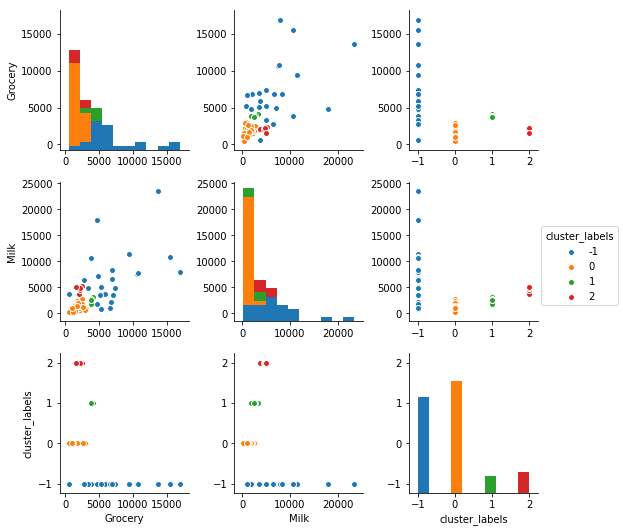

In [12]:
g = sns.pairplot(data1, hue="cluster_labels")

Additional Resources:
   - https://blog.dominodatalab.com/topology-and-density-based-clustering/
   - http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
   - https://www.cse.buffalo.edu/~jing/cse601/fa12/materials/clustering_density.pdf
   - https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Working%20With%20Markdown%20Cells.ipynb
   - http://data-blog.udacity.com/posts/2016/10/latex-primer/